In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
physical_devices = tf.test.gpu_device_name()
print(physical_devices)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import datasets

import numpy as np

/device:GPU:0


c:\Users\Tim\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ds_preprocess_image(entity):
    img = entity["image"]
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    entity["image"] = resize
    return entity

In [3]:
def preprocess_image(img):
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    return np.array(resize)

In [4]:
preprocess = False 
# preprocess the images from pil format into tensors, this is expensive and takes some time
if preprocess:

    # load image data

    ds = datasets.load_from_disk("../../data/diffusion_and_real/")

    train_images = np.array([preprocess_image(image) for image in ds["train"]["image"]])
    train_labels = np.array(ds["train"]["label"])

    vali_images = np.array([preprocess_image(image) for image in ds["vali"]["image"]])
    vali_labels = np.array(ds["vali"]["label"])

    test_images = np.array([preprocess_image(image) for image in ds["test"]["image"]])
    test_labels = np.array(ds["test"]["label"])

    ds_map = ds.map(ds_preprocess_image)

    ds_tf = ds_map.with_format("tf")

    ds_tf.save_to_disk("ds-tf")
else:
    ds_tf = datasets.load_from_disk("ds-tf")

In [5]:
ds_tf_train = ds_tf["train"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_vali = ds_tf["vali"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_test = ds_tf["test"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

c:\Users\Tim\miniconda3\lib\site-packages\datasets\arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [6]:
ds_tf_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
# define the model
# each convolution layer is followed by a max pooling layer
model = models.Sequential()
model.add(layers.Conv2D(8, (9, 9), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(16, (7, 7), strides=(4,4),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Fully connected layers
model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu')) removed for now to keep the network simple and fast 
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 504, 504, 8)       1952      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        6288      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [8]:
# review the model inputs / outputs
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 512, 512, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
conv2d (None, 512, 512, 3) float32
max_pooling2d (None, 504, 504, 8) float32
conv2d_1 (None, 126, 126, 8) float32
max_pooling2d_1 (None, 30, 30, 16) float32
flatten (None, 15, 15, 16) float32
dense (None, 3600) float32


[None, None, None, None, None, None]

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # dear god let this be the right loss function
              metrics=['accuracy'])

history = model.fit(ds_tf_train, epochs=3, batch_size = 32, max_queue_size=1, shuffle=False,
                    validation_data=ds_tf_vali
                    )

Epoch 1/3
6000/6000 [==============================] - 250s 41ms/step - loss: 0.7113 - accuracy: 0.5312 - val_loss: 0.6606 - val_accuracy: 0.5660
Epoch 2/3
6000/6000 [==============================] - 234s 39ms/step - loss: 0.6725 - accuracy: 0.5663 - val_loss: 0.6629 - val_accuracy: 0.5990
Epoch 3/3
6000/6000 [==============================] - 217s 36ms/step - loss: 0.6589 - accuracy: 0.5933 - val_loss: 0.6446 - val_accuracy: 0.6100


In [42]:
model.save("CNN")

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


334/334 - 10s - loss: 0.6529 - accuracy: 0.5760 - 10s/epoch - 30ms/step


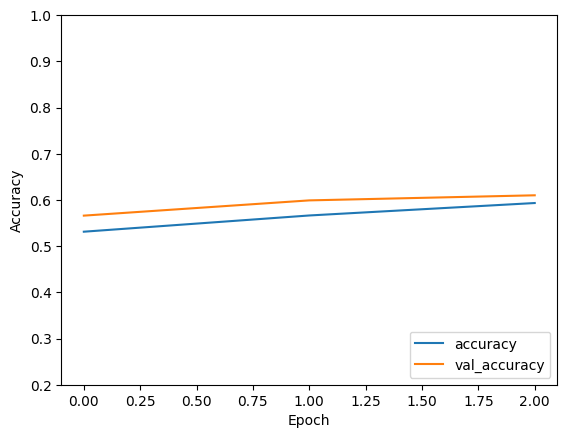

In [24]:
# plot model training
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_tf_test, verbose=2)


In [25]:
print(test_acc)


0.5759999752044678


In [18]:
true_label = ds_tf["vali"]["label"]

In [21]:
# eval test set
from tqdm import tqdm
# confusion matrix
predictions = []
res = model.predict(ds_tf_vali, batch_size=10)
predictions = [int(np.array(tf.nn.softmax(pred, axis=-1))[0]) for pred in res]

334/334 [==============================] - 10s 30ms/step


In [23]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


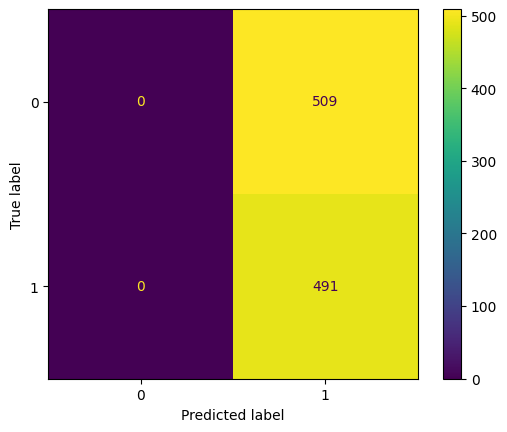

c:\Users\Tim\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tim\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tim\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 509.0},
 '1': {'precision': 0.491,
  'recall': 1.0,
  'f1-score': 0.658618376928236,
  'support': 491.0},
 'accuracy': 0.491,
 'macro avg': {'precision': 0.2455,
  'recall': 0.5,
  'f1-score': 0.329309188464118,
  'support': 1000.0},
 'weighted avg': {'precision': 0.241081,
  'recall': 0.491,
  'f1-score': 0.3233816230717639,
  'support': 1000.0}}

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


cm = confusion_matrix(true_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
classification_report(true_label, predictions, output_dict=True)


In [20]:
ds_tf_vali

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
model.evaluate(ds_tf_vali, verbose=2)

334/334 - 10s - loss: 0.6446 - accuracy: 0.6100 - 10s/epoch - 30ms/step


[0.6445906758308411, 0.6100000143051147]

In [30]:
res = model.predict(ds_tf_vali)

334/334 [==============================] - 10s 31ms/step


In [40]:
res

array([[-1.10869169e-01],
       [-1.10869169e-01],
       [-4.97944057e-02],
       [ 2.29506922e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 1.20567160e+01],
       [-1.10869169e-01],
       [ 3.69280159e-01],
       [ 1.12947309e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-4.39821184e-03],
       [ 4.70410633e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.13222957e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 1.09725928e+00],
       [ 1.79435515e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.07512206e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-8.39001179e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 1.19286394e+00],
       [-1.10869169e-01],
       [-1.03900015e-01],
       [-5.13718987e+00],
       [ 2.2

In [41]:
res_2 = model.predict(ds_tf["test"]["image"])
res_2

32/32 [==============================] - 3s 64ms/step


array([[-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 2.42730930e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 2.39793316e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-9.90322530e-02],
       [-1.10869169e-01],
       [ 1.01128423e+00],
       [ 1.25398481e+00],
       [-1.10869169e-01],
       [ 6.15534973e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 2.25400233e+00],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [ 8.94894481e-01],
       [-1.10869169e-01],
       [-1.10869169e-01],
       [-5.71108907e-02],
       [-1.1